In [1]:
from pandas import read_csv
from autoencoder.autoencoder import AnomalyDetector
from turtleIsolationForests.preprocessFeatures import minmax_preprocess_features, minmax_preprocess_denoised_features
from turtleIsolationForests.printResults import calc_confusion
from tensorflow.keras.losses import mae
from matplotlib import pyplot as plt
import numpy as np

In [2]:
train_dataframe = read_csv("./eda_simple_classification/network_data_mod_train.csv", index_col=0)
test_dataframe = read_csv("./eda_simple_classification/network_data_mod_test.csv", index_col=0)
robust_ae_train_dataframe = read_csv('./Robust_Autoencoder_Cleaned_Training_Normals.csv', index_col=0)
X_train, X_test, train_labels, test_labels = minmax_preprocess_features(train_dataframe, test_dataframe)
X_train_ae = minmax_preprocess_denoised_features(robust_ae_train_dataframe)
X_test_normals = X_test[~test_labels]
X_test_anomalies = X_test[test_labels]

In [3]:
contamination = sum(train_labels) / len(train_labels)
contamination

0.4654171925730117

In [4]:
autoenc = AnomalyDetector()
autoenc.compile(optimizer='adam', loss='mae')

In [5]:
losses = []
val_losses = []
test_normal_losses = []
test_anomaly_losses = []

In [6]:
i = 0

In [7]:
while i < 20:
    history = autoenc.fit(X_train_ae, X_train_ae, initial_epoch=i, epochs=i+1, validation_split=0.2, shuffle=True)
    reconstructions_n = autoenc.predict(X_test_normals)
    reconstructions_a = autoenc.predict(X_test_anomalies)
    test_loss_normal = mae(X_test_normals, reconstructions_n)
    test_loss_anomaly = mae(X_test_anomalies, reconstructions_a)
    test_loss_normal_m = np.mean(test_loss_normal)
    test_loss_anomaly_m = np.mean(test_loss_anomaly)
    print("test loss on normals: " + str(test_loss_normal_m) + ", test loss on anomalies: " + str(test_loss_anomaly_m))
    losses.append(history.history["loss"][0])
    val_losses.append(history.history["val_loss"][0])
    test_normal_losses.append(test_loss_normal_m)
    test_anomaly_losses.append(test_loss_anomaly_m)
    i += 1

402/402 [==============================] - 1s 1ms/step
test loss on normals: 0.038259327, test loss on anomalies: 0.21625689
Epoch 2/2
402/402 [==============================] - 1s 1ms/step
test loss on normals: 0.03776205, test loss on anomalies: 0.21291037
Epoch 3/3
402/402 [==============================] - 1s 1ms/step
test loss on normals: 0.03739539, test loss on anomalies: 0.21117781
Epoch 4/4
402/402 [==============================] - 1s 1ms/step
test loss on normals: 0.037340112, test loss on anomalies: 0.20910674
Epoch 5/5
402/402 [==============================] - 1s 1ms/step
test loss on normals: 0.037271436, test loss on anomalies: 0.20878017
Epoch 6/6
402/402 [==============================] - 1s 1ms/step
test loss on normals: 0.04393615, test loss on anomalies: 0.20304471
Epoch 7/7
402/402 [==============================] - 1s 1ms/step
test loss on normals: 0.04590335, test loss on anomalies: 0.19807394
Epoch 8/8
402/402 [==============================] - 1s 1ms/step
test

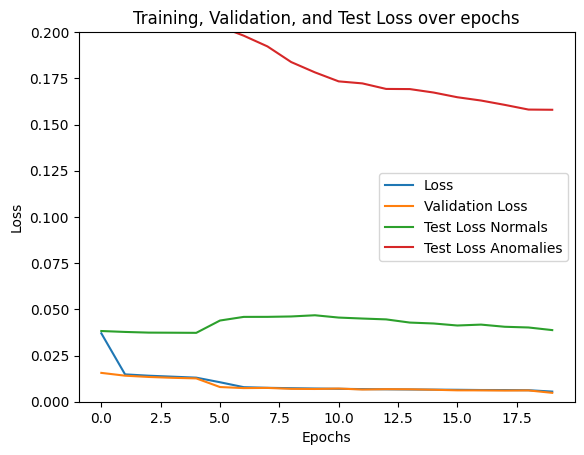

In [8]:
plt.plot(losses)
plt.plot(val_losses)
plt.plot(test_normal_losses)
plt.plot(test_anomaly_losses)
plt.title("Training, Validation, and Test Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, .2])
plt.legend(["Loss", "Validation Loss", "Test Loss Normals", "Test Loss Anomalies"])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

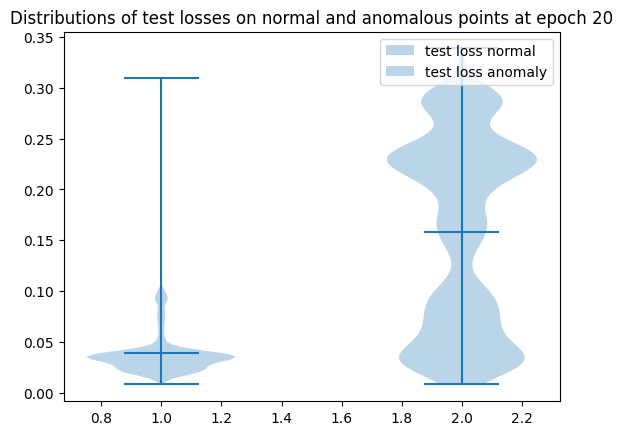

In [9]:
plt.violinplot([test_loss_normal, test_loss_anomaly], showmeans=True, showmedians=False)
plt.title("Distributions of test losses on normal and anomalous points at epoch " + str(i))
plt.legend(["test loss normal", "test loss anomaly"])
plt.show

In [16]:
contamination + 0.3 * (1 - contamination)

0.6257920348011081

In [23]:
from time import time
from turtleIsolationForests.printResults import calc_confusion, get_auroc_value, calc_f1, print_by_result
test_labels_np = test_labels.to_numpy()
start_time = time()
ae_scores, ae_predictions = autoenc.pipeline_predict(X_test, contamination)
ae_time = time() - start_time
ae_TA, ae_FA, ae_FN, ae_TN = calc_confusion(ae_predictions, test_labels_np)
ae_auroc = get_auroc_value(ae_scores, test_labels_np)
ae_precision, ae_recall, ae_f1 = calc_f1(ae_TA, ae_FA, ae_FN, ae_TN)
print("Autoencoder Results")
print_by_result(ae_TA, ae_FA, ae_FN, ae_TN, ae_precision, ae_recall, ae_f1)
print("auroc: " + str(ae_auroc))
print("test set prediction time: " + str(ae_time))

705/705 [==============================] - 1s 1ms/step
Autoencoder Results
true anomalies: 10712
false anomalies: 3384
false normals: 2121
true normals: 6327
precision: 0.7599318955732123
recall: 0.8347229798176576
f1-score: 0.7955735452486168
auroc: 0.8624767990033931
test set prediction time: 1.365999460220337
